In [2]:
# Run this cell only if you are running this in google colab
# !git clone https://github.com/codyarvonen/2048
# import sys
# sys.path.append('/content/2048')

In [3]:
import math
import random
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from game import Game
from direction import Direction

In [4]:
def play_random_game(save: bool=False):
    # Initialize the random game
    random_seed = random.randint(0, 2**32 - 1)
    random_game = Game(seed=random_seed, iterative_mode=True, save_game=save, visualize=False)
    board = random_game.init_board()

    # Step through the game loop
    total_score = 0
    game_over = False
    count = 0
    while not game_over:
        board, reward, game_over = random_game.step(board, random.choice(list(Direction)))
        total_score += reward.action_score
        count += 1

    if save:
        random_game.history.final_board = board
        random_game.store_history('test_random_games')

    return board, total_score, count

In [3]:
def print_game_stats_from_file(file: str):
    with open(file, 'rb') as f:
        game_history = pickle.load(f)
        print(game_history.final_board)
        # Game(seed=game_history.seed, command_list=game_history.action_list).run() 

In [22]:
def plot_score_dist(scores):
    # Score distribution
    plt.hist(scores, bins = 100)
    plt.title("Total score distribution")
    plt.xlabel("Total Score")
    plt.ylabel("Frequency")
    plt.show()

def plot_best_tile_dist(tiles):
    # Best tile distribution
    max_power = int(math.log(max(tiles), 2)) + 1
    min_power = int(math.log(min(tiles), 2))
    unique, counts = np.unique(tiles, return_counts=True)
    plt.bar([str(2 ** i) for i in range(min_power, max_power)], counts)
    plt.title("Best tile distribution")
    plt.xlabel("Best tile")
    plt.ylabel("Frequency")
    plt.show()

**Baseline**

In [36]:
baseline_episodes = 500
baseline_scores = []
baseline_best_tiles = []
save_random_games = False

iterations = []

for episode in tqdm(range(baseline_episodes), total=baseline_episodes):
    board, score, num_iterations = play_random_game(save=save_random_games)
    baseline_scores.append(score)
    baseline_best_tiles.append(np.amax(board))
    iterations.append(num_iterations)

np.mean(np.array(iterations))


100%|██████████| 500/500 [00:11<00:00, 43.46it/s]


140.346

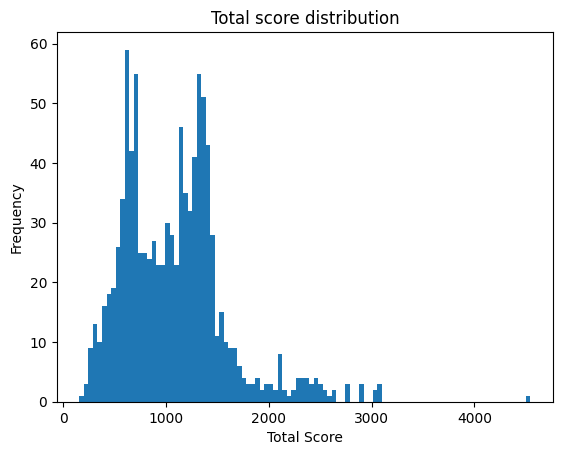

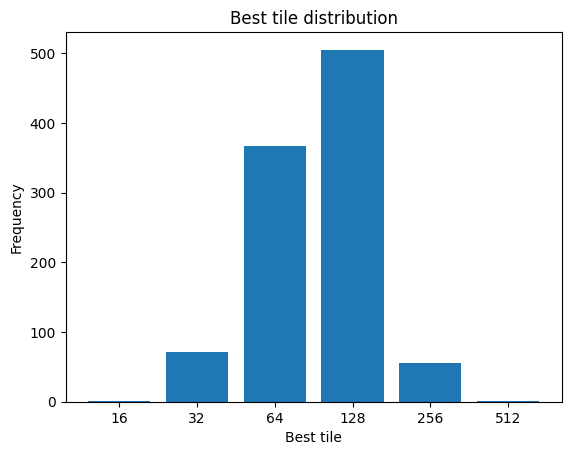

In [6]:
plot_score_dist(baseline_scores)
plot_best_tile_dist(baseline_best_tiles)

**Training**

In [5]:
from memory import ReplayMemory, Experience
from qnet import QNet
import torch
import torch.nn as nn
import torch.optim as optim

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [7]:
# TODO: refactor constants
MEM_CAPACITY = 50000
NUM_STATES = 16
NUM_ACTIONS = 4
LEARNING_RATE = 5e-5
EPISODES = 20000
EPSILON_START = 0.9
EPSILON_END = 0.01
EPSILON_DECAY = 0.999
UPDATE_TARGET = 25
BATCH_SIZE = 128
LEARN_ITERATIONS = 50
GAMMA = 0.99

# TODO: decay the LR?

save_episodes = True

# Initialize replay memory
replay_memory = ReplayMemory(MEM_CAPACITY)

# Initialize action-value function and target action-value function
qnet = QNet(NUM_STATES, NUM_ACTIONS, device).to(device)
qnet_target = QNet(NUM_STATES, NUM_ACTIONS, device).to(device)
qnet.train()
qnet_target.eval()

# Initialize optimization functions
criterion = nn.MSELoss()
optimizer = optim.Adam(qnet.parameters(), lr=LEARNING_RATE)

# Iterate through the episodes
iterations = 0
epsilon = EPSILON_START
trained_scores = []
trained_best_tiles = []
losses = []
for episode in tqdm(range(EPISODES), total=EPISODES):
    # Initialize game for episode
    episode_game = Game(seed=random.randint(0, (2**32)-1), iterative_mode=True, save_game=save_episodes, visualize=False)

    # Initialize the board
    board = episode_game.init_board()

    # Step through the episode
    episode_score = 0
    episode_done = False
    while not episode_done:

        # TODO: add functionality to save an episode or every C episodes

        # With probability epsilon select a random action, else choose from policy
        if random.uniform(0, 1) < epsilon:
            action = random.choice(list(Direction))
        else:
            qnet.eval()
            with torch.no_grad():
                action = torch.argmax(qnet(board))
                action = Direction(action.item())
            qnet.train()
        
        # # Update epsilon
        # epsilon = epsilon * EPSILON_DECAY
        # epsilon = max(epsilon, EPSILON_END)

        # Execute action and observe reward
        result = episode_game.step(board, action)
        reward = result[1].get_total_reward()
        episode_score += result[1].action_score
        
        replay_memory.memory.append(Experience(board, action, reward, result[0]))

        board = result[0]
        episode_done = result[2]

        if episode_done:
            # Optimize model if 
            if len(replay_memory) > BATCH_SIZE:
                for i in range(LEARN_ITERATIONS):
                    experiences = replay_memory.sample(BATCH_SIZE)
                    states = []
                    actions = []
                    rewards = []
                    next_states = []
                    for experience in experiences:
                        states.append(experience.state)
                        actions.append(experience.action)
                        rewards.append(experience.reward)
                        next_states.append(experience.next_state)
                                        
                    states = np.array(states)
                    actions = torch.tensor([act.value for act in actions]).unsqueeze(1)
                    rewards = torch.tensor(rewards)
                    next_states = np.array(next_states)
                    
                    # Get the Q values for each action
                    q_vals = qnet(states)

                    # Gather the Q values for the action that was taken
                    estimated_actions = torch.gather(q_vals, 1, actions)

                    expected_actions = qnet_target(next_states).max(1)[0].detach().float()
                    expected_actions = (expected_actions * GAMMA) + rewards
                    expected_actions = expected_actions.float()

                    # TODO: keep track of loss vals to plot afterwards

                    loss = criterion(estimated_actions, expected_actions.unsqueeze(1))

                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    losses.append(loss.detach())

    trained_scores.append(episode_score)
    trained_best_tiles.append(np.amax(board))

    # Update epsilon
    epsilon = epsilon * EPSILON_DECAY
    epsilon = max(epsilon, EPSILON_END)

    if save_episodes:
        episode_game.store_history('training_episodes_2')

    # Every C steps reset target model
    if episode % UPDATE_TARGET == 0:
        qnet_target.load_state_dict(qnet.state_dict())
        qnet.train()

 13%|█▎        | 2605/20000 [2:27:07<16:22:26,  3.39s/it]


KeyboardInterrupt: 

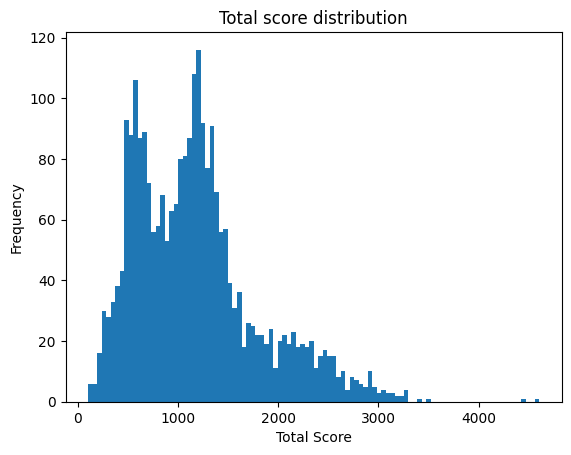

In [8]:
# Score distribution
plt.hist(trained_scores, bins = 100)
plt.title("Total score distribution")
plt.xlabel("Total Score")
plt.ylabel("Frequency")
plt.show()

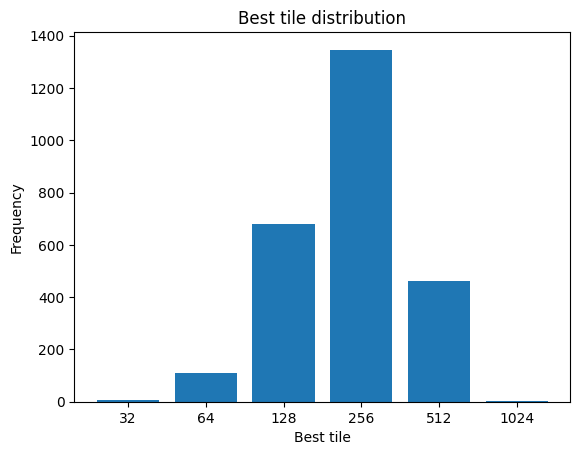

In [9]:
import math

# Best tile distribution
max_power = int(math.log(max(trained_best_tiles), 2)) + 1
min_power = int(math.log(min(trained_best_tiles), 2))
unique, counts = np.unique(trained_best_tiles, return_counts=True)
plt.bar([str(2 ** i) for i in range(min_power, max_power)], counts)
plt.title("Best tile distribution")
plt.xlabel("Best tile")
plt.ylabel("Frequency")
plt.show()

In [16]:
eps = 0.9
count = 0
while (eps := eps * 0.999) > 0.001:
    count += 1

print(count)


6798


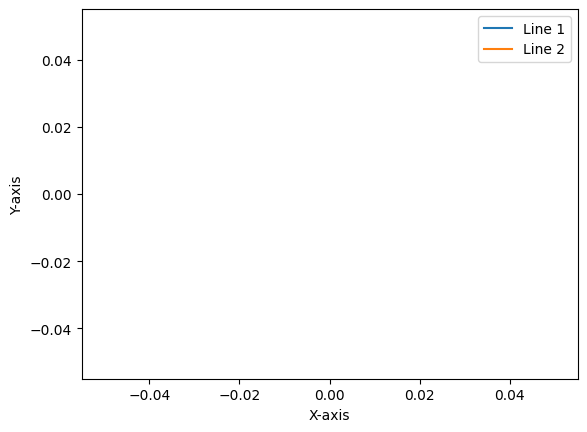

0.06642618919704914
[]
[]
[35.527217864990234, 33.245826721191406, 30.82819938659668, 33.21164321899414, 27.800941467285156, 34.00489807128906, 29.342565536499023, 37.095672607421875, 31.663021087646484, 28.537033081054688, 33.152488708496094, 31.66199493408203, 31.64649772644043, 30.889751434326172, 36.23446273803711, 34.770118713378906, 35.4962158203125, 33.20905303955078, 36.2876091003418, 35.481163024902344, 33.17679977416992, 32.41087341308594, 34.722938537597656, 35.50957489013672, 33.18958282470703, 29.32674217224121, 33.16838455200195, 35.50153732299805, 37.78506088256836, 33.94728088378906, 31.593957901000977, 26.985498428344727, 29.322223663330078, 31.607498168945312, 36.234825134277344, 33.18373107910156, 38.584163665771484, 32.424800872802734, 33.130821228027344, 31.58650016784668, 33.92129135131836, 31.59160804748535, 34.6861572265625, 36.273216247558594, 40.11619186401367, 34.75710678100586, 37.72449493408203, 32.36540603637695, 35.46247863769531, 33.151832580566406, 267.

In [53]:

loss_vals = [item.detach().numpy().tolist() for item in losses]

plt.plot(trained_best_tiles)
plt.plot(trained_scores)
# plt.plot(loss_vals)

# add labels and legend
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(['Line 1', 'Line 2', 'losses'])

# display the plot
plt.show()

print(epsilon)
print(trained_best_tiles)
print(trained_scores)
print([item.detach().numpy().tolist() for item in losses])



In [50]:
def play_game_from_model(save: bool=False):
    # Initialize the random game
    random_seed = random.randint(0, 2**32 - 1)
    trained_game = Game(seed=random_seed, iterative_mode=True, save_game=save, visualize=False)
    trained_board = trained_game.init_board()
    print('new game')
    # Step through the game loop
    total_score = 0
    game_over = False
    count = 0
    qnet.eval()
    while not game_over:
        trained_action = None
        with torch.no_grad():
            vals = qnet(trained_board)
            if count < 50:
                print(vals)
            trained_action = torch.argmax(vals)
            trained_action = Direction(trained_action.item())
        trained_board, reward, game_over = trained_game.step(trained_board, trained_action)
        total_score += reward.action_score
        count += 1
        if count < 50:
            print(f'{count} iterations')
            print(trained_action)
            print(f'top tile: {np.amax(trained_board)}')
            print(trained_board)

    if save:
        trained_game.history.final_board = trained_board
        trained_game.store_history('test_trained_games')

    qnet.train()
    
    return trained_board, total_score, count

In [51]:
trained_episodes = 500
trained_scores = []
trained_best_tiles = []
save_trained_games = False

iterations = []

for episode in tqdm(range(trained_episodes), total=trained_episodes):
    board, score, num_iterations = play_game_from_model(save=save_trained_games)
    trained_scores.append(score)
    trained_best_tiles.append(np.amax(board))
    iterations.append(num_iterations)

np.mean(np.array(iterations))

  0%|          | 0/500 [00:00<?, ?it/s]

new game
tensor([[0., 0., 0., 0.]])
1 iterations
Direction.LEFT
top tile: 2
[[2 0 0 0]
 [2 0 0 0]
 [0 0 2 0]
 [0 0 0 0]]
tensor([[0., 0., 0., 0.]])
2 iterations
Direction.LEFT
top tile: 2
[[2 0 0 0]
 [2 0 0 0]
 [2 0 0 0]
 [0 2 0 0]]
tensor([[0., 0., 0., 0.]])
3 iterations
Direction.LEFT
top tile: 2
[[2 0 0 0]
 [2 0 0 0]
 [2 0 0 0]
 [2 0 0 2]]
tensor([[0., 0., 0., 0.]])
4 iterations
Direction.LEFT
top tile: 4
[[2 0 0 0]
 [2 4 0 0]
 [2 0 0 0]
 [4 0 0 0]]
tensor([[0., 0., 0., 0.]])
5 iterations
Direction.LEFT
top tile: 4
[[2 0 0 0]
 [2 4 0 0]
 [2 0 0 0]
 [4 0 0 0]]
tensor([[0., 0., 0., 0.]])
6 iterations
Direction.LEFT
top tile: 4
[[2 0 0 0]
 [2 4 0 0]
 [2 0 0 0]
 [4 0 0 0]]
tensor([[0., 0., 0., 0.]])
7 iterations
Direction.LEFT
top tile: 4
[[2 0 0 0]
 [2 4 0 0]
 [2 0 0 0]
 [4 0 0 0]]
tensor([[0., 0., 0., 0.]])
8 iterations
Direction.LEFT
top tile: 4
[[2 0 0 0]
 [2 4 0 0]
 [2 0 0 0]
 [4 0 0 0]]
tensor([[0., 0., 0., 0.]])
9 iterations
Direction.LEFT
top tile: 4
[[2 0 0 0]
 [2 4 0 0]
 [2 0 

  0%|          | 0/500 [00:02<?, ?it/s]


KeyboardInterrupt: 

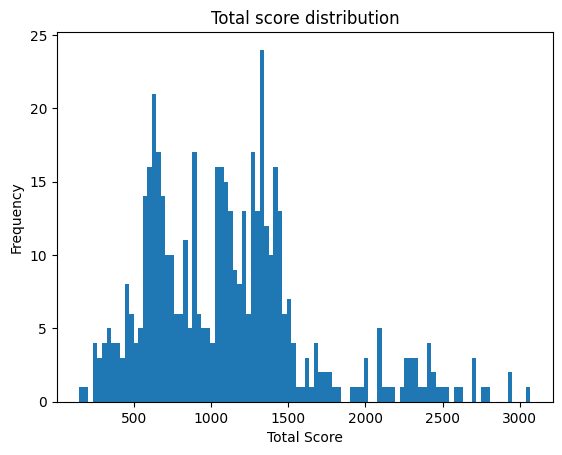

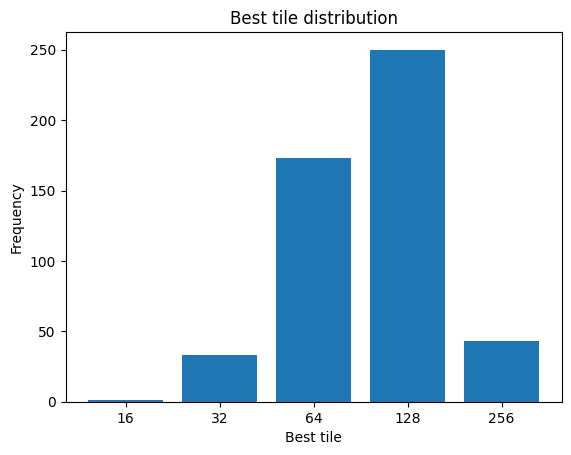

In [23]:
plot_score_dist(trained_scores)
plot_best_tile_dist(trained_best_tiles)